## Cold Atom integration into Qiskit demo notebook

In this notebook we will explore the typical workflow of how a user can communicate with a remote backend in Qiskit in the context of cold atom experiments.

A schematic of this is shown in the figure below. Red parts in the pseudocode highlight new classes and functionalities which we showcase in this notebook while yellow indicates where we can use existing classes from Qiskit without further modification. 
\
Blue dashed arrows indicate all points where requests are sent form the user to the backend url, while green dashed arrows symbolise the response to those requests. The remote backend in the diagram is simulated here with a mock API built in flask running on the localhost. This API needs to run in the background via `python flask_cold_atom_api.py` in order to execute the cells in this notebook.
\
A simple pip install qiskit should install all the required packages from Qiskit.

![](workflow_overview.png )



## I: Loading the backend

Let's first import the provider which manages the access to the backends. We print the list of available backends. 

In [1]:
from cold_atom_provider import ColdAtomProvider 

provider = ColdAtomProvider('token')
backend_list = provider.backends() 

print(backend_list)

c:\users\laurinfischer\anaconda3\envs\fermions\lib\site-packages\qiskit\aqua\operators\operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))


[<AtomicMixtureSimulator('atomic_mixtures_meanfield_simulator')>, <AtomicMixtureDevice('cold_atom_mixtures')>, <CoherentSpinsDevice('cold_atom_spins')>, <CoherentSpinsQubits('coherent_spin_qubits')>]


We select the `AtomicMixtureDevice` backend and take a look at the configuration of this backend:

In [2]:
backend = provider.get_backend('cold_atom_mixtures')
config_dict = backend.configuration().to_dict()

import pprint
pprint.pprint(config_dict)

{'atomic_species': ['na', 'li'],
 'backend_name': 'cold_atom_mixtures',
 'backend_version': '0.0.1',
 'basis_gates': ['rx', 'delay'],
 'conditional': False,
 'coupling_map': [[0, 1]],
 'credits_required': False,
 'description': 'Setup of an atomic mixtures experiment with one     trapping '
                'site and two atomic species, namely Na and Li.',
 'dynamic_reprate_enabled': False,
 'gates': [{'coupling_map': [[0, 1]],
            'description': 'evolution under SCC Hamiltonian for time tau',
            'name': 'delay',
            'parameters': ['tau', 'delta'],
            'qasm_def': 'gate delay(tau, delta) {}'},
           {'coupling_map': [[0]],
            'description': 'Rotation of the sodium spin',
            'name': 'rx',
            'parameters': ['theta'],
            'qasm_def': 'gate rx(theta) {}'}],
 'local': False,
 'max_experiments': 3,
 'max_shots': 60,
 'memory': True,
 'n_qubits': 2,
 'open_pulse': False,
 'simulator': False,
 'supported_instructions': ['d

In [3]:
print(type(backend))

<class 'bosonic_backends.AtomicMixtureDevice'>


This configuration file tells us all we need to know about the backend. In particular, it communicates to the user which gate instruction it will accept in a circuit, how many wires the circuit can have etc. We also see that it is currently running on the localhost.

## II: Building the quantum circuit

Here we demostrate how to build a quantum circuit for a cold atom device using the cold atom gate library and the `get_empty_circuit` method of the backend. This empty circuit will be initialized with the correct quantum and classical registers for the backend device. In this case, there is one wire for the sodium state, one wire for the lithium state and two classical wires for the two measurement outcomes.

In [4]:
circuit = backend.get_empty_circuit()

print("Quantum registers in the circuit: ", circuit.qregs)
print("Classical registers in the circuit: ", circuit.cregs)
circuit.draw()

Quantum registers in the circuit:  [QuantumRegister(1, 'na'), QuantumRegister(1, 'li')]
Classical registers in the circuit:  [ClassicalRegister(2, 'c2')]


na_0: 
      
li_0: 
      
c2: 2/

In [5]:
print(type(circuit))

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


We can now add gates from the library to this empty circuit and use qiskits `.draw` method for now. We aim to implement our own circuit drawer that more nicely differentiates between the two atomic species. 

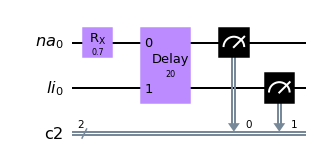

In [6]:
from circuit_library import MixturesRXGate, MixturesSCCdrift

circuit.append(MixturesRXGate(theta=0.7), qargs=[0])
circuit.append(MixturesSCCdrift(num_wires=2, tau=20) , qargs=[0, 1])

circuit.measure([0,1], circuit.cregs[0])
circuit.draw(output = 'mpl')

This circuit can be converted into a Json payload that is sent to the backend server with the `circuit_to_cold_atom` method:

In [7]:
from circuit_to_cold_atom import circuit_to_cold_atom

pprint.pprint(circuit_to_cold_atom(circuit, backend))

{'experiment_0': {'instructions': [('rx', [0], [0.7]),
                                   ('delay', [0, 1], [20.0]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 60}}


Under the `data` key, there is now a tuple for each instruction in the circuit. The first element is the name of that instruction, while the second element lists the indices of the wires that the instruction acts on. These are the total idices in the circuit, not the indices of the respective `QuantumRegister` (which would be all 0 here). The last element of that tuple gives the value of the prameters of that instruction (if any). 

This function will complain if the gates used do not match the backend. Let's try to add a gate that is not support, such as the Hadamard gate:

In [8]:
circuit_wrong = backend.get_empty_circuit()

circuit_wrong.h(0)

# uncommenting this will create an error
# circuit_to_cold_atom(circuit_wrong, backend)

This function also catches whether all applied gates match the coupling map of these gates on the backend:

In [9]:
circuit_wrong_2 = backend.get_empty_circuit()

circuit_wrong_2.append(MixturesRXGate(theta=0.7), qargs=[1])

# Uncommenting this will create an error:
# circuit_to_cold_atom(circuit_wrong_2, backend)

## III. Sending the circuit to the backend

We can now send this circuit to the backend. This creates a `ColdAtomJob` object. 

In [10]:
job = backend.run(circuit)
print(type(job))

<class 'cold_atom_job.ColdAtomJob'>


The backend has created a `job_id`, which serves as a unique identifier for this job:

In [11]:
print(job._job_id)

e7cc73b0-8c9a-11eb-835d-482ae31487c4


## IV: Checking for status 

In a realistic setting, the backend would now place this job in a queue, where it is stored until its execution. 
The backend does not automatically return the measurement result to the user.
Rather it is the user that has to make all requests. 

To check whether the job has finished, is running, or placed in the queue, Qiskit provides a `status` function:

In [12]:
print(job.status())

<Response [200]>
200
JobStatus.DONE


In our case, the circuit is not actually processed further, rather in this example the backend just directly returns a generic result and status as done.  

## V: Retrieving the result from the backend

To access the results of our circuit, we have to ask the backend for it. Internally the backend checks the `job_id` of the job and looks up the stored measurement outcomes. The backend then returns a Json dictionary which includes all information about the measurements and is turned into a `Qiskit.Result` object:

In [13]:
result = job.result()
print(type(result))

<class 'qiskit.result.result.Result'>


We can take a look at the dicitonary that the backend returned like this:

In [14]:
result_dict = result.to_dict()
pprint.pprint(result_dict)

{'backend_name': 'cold_atom_mixtures',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': 'e7cc73b0-8c9a-11eb-835d-482ae31487c4',
 'qobj_id': '1234',
 'results': [{'data': {'memory': [[[90012.0, 9988.0], [5100.0, 4900.0]],
                                  [[89900.0, 10100.0], [5000.0, 5000.0]],
                                  [[90000.0, 10000.0], [5050.0, 4950.0]]]},
              'header': {'name': 'experiment_0'},
              'meas_level': 1,
              'meas_return': 'single',
              'shots': 3,
              'success': True}],
 'status': 'finished',
 'success': 'true'}


## VI: Processing the result

The actual measurement datta is stored under the `results` key. In this case, the `meas_return` is single, so the data of each experimental shot is directly stored in `memory`. This can be directly accessed from the result object:

In [15]:
outcomes = result.get_memory()
print(outcomes)

[[90012. +9988.j  5100. +4900.j]
 [89900.+10100.j  5000. +5000.j]
 [90000.+10000.j  5050. +4950.j]]


The data above should serve as an example of how the measurement results for the NaLi experiment may be communicated. Each line is one experimental shot, where the first two numbers are the sodium atoms found in the two spin states, respectively, and the other two are the lithium numbers per spin state. 
\
They are currently cast into complex numbers internally, because this is how Qiskit processes the data it expects for `meas_level = 1`. 
\
In any case we can also directly access the outcome memory through the associated dictionary:

In [16]:
pprint.pprint(result_dict['results'][0]['data']['memory'])

[[[90012.0, 9988.0], [5100.0, 4900.0]],
 [[89900.0, 10100.0], [5000.0, 5000.0]],
 [[90000.0, 10000.0], [5050.0, 4950.0]]]
